# Diffusion models for ultrasound image generation

In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import keras
from zea import log, init_device
from zea.models.diffusion import DiffusionModel
from zea.ops import Pipeline, ScanConvert
from zea.data import Dataset
from zea.visualize import plot_image_grid, set_mpl_style
from zea.agent.selection import EquispacedLines
from zea.utils import translate

zea: Using backend 'jax'


In [2]:
init_device()
set_mpl_style()

-------------------GPU settings-------------------
     memory
GPU        
0        2570
1         932
2       10852
3       10852
4       11011
5       11011
6       11011
7         926
Selecting 1 GPU based on available memory.
Selected GPU 4 with Free Memory: 11011.00 MiB
Hiding GPUs [0, 1, 2, 3, 5, 6, 7] from the system.
--------------------------------------------------


In [3]:
presets = list(DiffusionModel.presets.keys())
log.info(f"Available built-in zea presets for DiffusionModel: {presets}")

model = DiffusionModel.from_preset("diffusion-echonet-dynamic") # or use a local path to your model

# Prior sampling
prior_samples = model.sample(n_samples=16, n_steps=90, verbose=True)

zea: Available built-in zea presets for DiffusionModel: ['diffusion-echonet-dynamic']
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step


In [4]:
pipeline = Pipeline([ScanConvert(order=1, jit_compile=False)])
parameters = {
    "theta_range": [-0.78, 0.78],  # [-45, 45] in radians
    "rho_range": [0, 1],
}
processed_batch = keras.ops.squeeze(prior_samples, axis=-1)

parameters = pipeline.prepare_parameters(**parameters)
processed_batch = pipeline(data=processed_batch, **parameters)["data"]

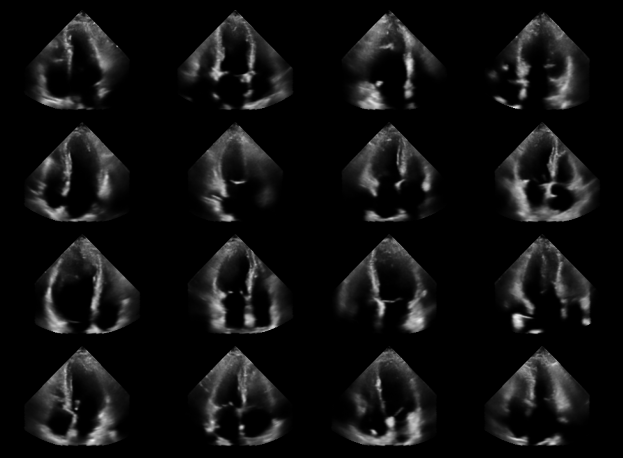

In [5]:
fig, _ = plot_image_grid(
    processed_batch, vmin=-1, vmax=1,
)

In [6]:
dataset = Dataset("hf://zeahub/camus-sample/val", key="image")

data = dataset[0]["data"]["image"]

img_shape = model.input_shape[:2]

data = keras.ops.expand_dims(data, axis=-1)
data = keras.ops.image.resize(data, img_shape)
dynamic_range = (-40, 0)
data = keras.ops.clip(data, dynamic_range[0], dynamic_range[1])
data = translate(data, dynamic_range, (-1, 1))


zea: Using pregenerated dataset info file: /home/devcontainer0/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/dataset_info.yaml ...
zea: ...for reading file paths in /home/devcontainer0/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val
zea: Dataset was validated on June 08, 2025
zea: Remove /home/devcontainer0/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/validated.flag if you want to redo validation.


In [7]:
line_thickness = 2
factor = 2
agent = EquispacedLines(
    n_actions=img_shape[1] // line_thickness // factor,
    n_possible_actions=img_shape[1] // line_thickness,
    img_width=img_shape[1],
    img_height=img_shape[0],
)

_, mask = agent.sample(batch_size=len(data))
mask = keras.ops.expand_dims(mask, axis=-1)

measurements = keras.ops.where(mask, data, -1.0)

In [8]:
## Posterior sampling
posterior_samples = model.posterior_sample(
    measurements=measurements,
    mask=mask,
    n_samples=4,
    n_steps=200,
    omega=30.0,
    verbose=True,
)
posterior_variance = keras.ops.var(posterior_samples, axis=1)
posterior_samples = posterior_samples[:, 0]  # Get first sample only
# scale posterior variance to [-1, 1] range so it can be visualized
posterior_variance = translate(
    posterior_variance,
    (0, keras.ops.max(posterior_variance)),
    (-1, 1),
)

## Post processing (ScanConvert)
concatenated = [prior_samples, data, measurements, posterior_samples, posterior_variance]
# limit number of samples for visualization
concatenated = [sample[:4] for sample in concatenated]
concatenated = keras.ops.concatenate(concatenated, axis=0)
concatenated = keras.ops.squeeze(concatenated, axis=-1)

processed_batch = pipeline(data=concatenated, **parameters)["data"]


200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - error: 20044.3438


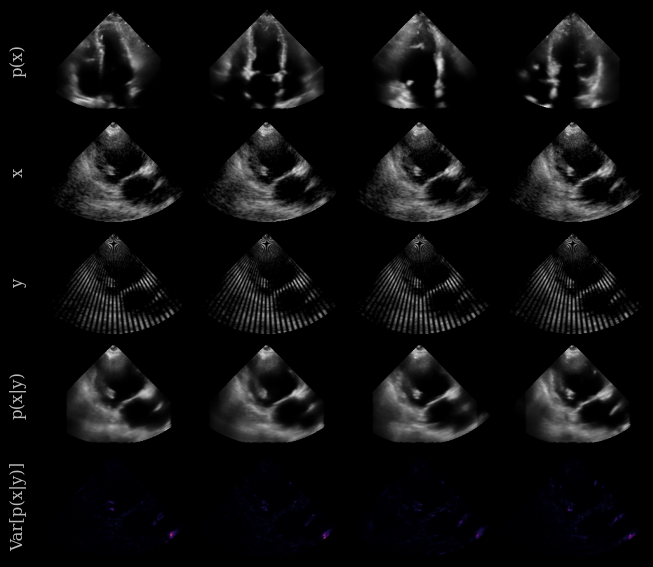

In [9]:
n_rows = 5  # prior, batch, measurements, posterior, posterior_variance
imgs_per_row = 4

cmaps = ["gray"] * ((n_rows - 1) * imgs_per_row) + ["inferno"] * imgs_per_row

## Plotting
fig, _ = plot_image_grid(
    processed_batch,
    vmin=-1,
    vmax=1,
    remove_axis=False,
    ncols=imgs_per_row,
    cmap=cmaps,
)

titles = ["p(x)", "x", "y", "p(x|y)", "Var[p(x|y)]"]

for i, title in enumerate(titles):
    fig.axes[i * imgs_per_row].set_ylabel(title)